In [1]:
import akantu as aka
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Lenght of the bar (m)
L = 50*10**-3  
# Number of linear elements (n_el)
n_el = 5
# Lenght of each linear element (h)
h = L/n_el
# Cross sectional area (m2)
A = 1*10**-3 

# Applied strain rate (s-1)
# strain_rate = 10.0**2
# strain_rate = 10.0**3
strain_rate = 10.0**4
# strain_rate = 10.0**5

# Applied velocity
vel = strain_rate*L/2 


# Limit stress / critical stress (stress_c) (Pa)
stress_c = 300.0*10**6 
# Young's module (Pa)
E = 275.0*10**9  

In [3]:
# Read material file
aka.parseInput('material.dat')

# Read mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read('../LOG/bar.msh')

# Create model
model = aka.SolidMechanicsModelCohesive(mesh)
model.initFull(_analysis_method=aka._static, _is_extrinsic=True)


# Configure static solver
solver = model.getNonLinearSolver('static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

# Solver (explicit Newmark with lumped mass)
model.initNewSolver(aka._explicit_lumped_mass)
# Dynamic insertion of cohesive elements
model.updateAutomaticInsertion()

In [4]:
# Critical time step
critical_time_step = model.getStableTimeStep()
# Adopted time step
dt = critical_time_step*0.1

# Total time of simulation (s)
time_simulation = 6.0*10**-7

# Number of time steps (n_steps)
n_steps = int(time_simulation/dt)
print(n_steps)

11


In [5]:
class FixedVelocity (aka.DirichletFunctor):
    """
    Fixed velocity at the boundaries
    """

    def __init__(self, axis, vel):
        super().__init__(axis)
        self.axis = axis
        self.time = 0
        self.vel = vel
    
    def set_time(self, t):
        self.time = t
    
    def __call__(self, node, flags, disp, coord):
        flags[int(self.axis)] = True
        disp[int(self.axis)] = self.vel*self.time
        

In [6]:
# Apply BCs

# Apply Dirichlet BC to block dispacements at y direction on top and botton of the elements
model.applyBC(aka.FixedValue(0., aka._y), 'YBlocked')

# Apply constant velocity at the boundaries
functor_left = FixedVelocity(aka._x, -vel)
functor_right = FixedVelocity(aka._x, vel)
model.applyBC(functor_left, 'left')
model.applyBC(functor_right, 'right')



In [7]:
# Initial value 

n_nodes = mesh.getNbNodes()
u0 = model.getDisplacement()
v0 = model.getVelocity()

# Initial velocity profile
v0[:,0] = np.array([strain_rate * x for x,y in mesh.getNodes()])

# Initial displacement (u0) 
if strain_rate < 5.0 * 10.0**3:
    u0[:,0] = np.array([0.98*stress_c*x / E for x,y in mesh.getNodes()])


In [8]:
# Main algorithm

# Initiation of variables
Epot = np.zeros(n_steps)
Ekin = np.zeros(n_steps)
Edis = np.zeros(n_steps)
Erev = np.zeros(n_steps)
Econ = np.zeros(n_steps)
Wext = np.zeros(n_steps)
work = 0.0
fp_left = 0.0
fp_right = 0.0
avg_stress = np.zeros(n_steps)


for n in range(n_steps):


    # Apply velocity at the boundaries 
    functor_left.set_time(dt*n)
    functor_right.set_time(dt*n)
    model.applyBC(functor_left, 'left')
    model.applyBC(functor_right, 'right')
    


    # Outputs
    u = model.getDisplacement()[:,0]
    v = model.getVelocity()[:,0]
    a = model.getAcceleration()[:,0]
    fint = model.getInternalForce()[:,0]
    stress = model.getMaterial(0).getStress(aka._triangle_3)
    stress_xx = stress[:,0]
    avg_stress = np.mean(stress_xx)


    # Energy balance
    # External energy
    # Reaction force at the boundaries 
    nodes_left = mesh.getElementGroup('left').getNodeGroup().getNodes()
    nodes_right = mesh.getElementGroup('right').getNodeGroup().getNodes()
    # Current time step (fn)
    fn_left = -np.sum(fint[nodes_left])
    fn_right = -np.sum(fint[nodes_right])
    # The reaction force (fr) is taken as an average between fn (current time step) and fp (previous time step)
    fr_left = (fn_left + fp_left)*0.5
    fr_right = (fn_right + fp_right)*0.5
    # Stress at the boundary
    stress_bound_left = fr_left 
    stress_bound_right = fr_right 
    # External work (Wext)
    Wext[n] = work + (stress_bound_left * -vel + stress_bound_right * vel)*dt 
    work = Wext[n]
    fp_left = fn_left
    fp_right = fn_right
    
    # Get other energies
    Epot[n] = model.getEnergy('potential')
    Ekin[n] = model.getEnergy('kinetic')
    Edis[n] = model.getEnergy('dissipated')
    Erev[n] = model.getEnergy('reversible')
    Econ[n] = model.getEnergy('cohesive contact')


    # Run simulation
    model.checkCohesiveStress()
    model.solveStep('explicit_lumped')





    # Fragmentation
    
print(Epot)
print(Wext)

[   0.            0.           59.05264226  236.50862256  537.08411459
  965.57069806 1522.52958412 2208.52297051 3024.11404157 3969.86696827
 5046.34690817]
[   0.            0.           59.08988721  221.81068763  507.67910984
  936.26858713 1493.36781163 2179.5389339  2995.34509118 3941.35040735
 5018.11999294]


In [9]:
def VarEnergy(Epot, Ekin, Edis, Erev, Econ, Wext):
    """Returns the variation of energies between the current time step and the time step 0."""

    varEkin = np.zeros((n_steps))
    varEpot = np.zeros((n_steps))
    varEdis = np.zeros((n_steps))
    varWext = np.zeros((n_steps))
    varErev = np.zeros((n_steps))
    varEcon = np.zeros((n_steps))
    varEtot = np.zeros((n_steps))
    for n in range(1,n_steps):
        varEpot[n] = Epot[n] - Epot[0]
        varEkin[n] = Ekin[n] - Ekin[0]
        varEdis[n] = Edis[n] - Edis[0]
        varErev[n] = Erev[n] - Erev[0]
        varEcon[n] = Econ[n] - Econ[0]
        varWext[n] = Wext[n] - Wext[0]
        varEtot[n] = varWext[n] - (varEpot[n] + varEkin[n] + varEdis[n]  + varErev[n] + varEcon[n])

    return varEkin, varEpot, varEdis, varErev, varEcon, varWext, varEtot


def Power(Epot, Ekin, Edis, Erev, Econ, Wext):
    """Returns the variation of energies between two consecutives time steps."""

    PEkin = np.zeros((n_steps))
    PEpot = np.zeros((n_steps))
    PEdis = np.zeros((n_steps))
    PWext = np.zeros((n_steps))
    PErev = np.zeros((n_steps))
    PEcon = np.zeros((n_steps))
    PEtot = np.zeros((n_steps))
    for n in range(1,n_steps):
        PEpot[n] = Epot[n] - Epot[n-1]
        PEkin[n] = Ekin[n] - Ekin[n-1]
        PEdis[n] = Edis[n] - Edis[n-1]
        PErev[n] = Erev[n] - Erev[n-1]
        PEcon[n] = Econ[n] - Econ[n-1]
        PWext[n] = Wext[n] - Wext[n-1]
        PEtot[n] = PWext[n] - (PEpot[n] + PEkin[n] + PEdis[n]  + PErev[n] + PEcon[n])

    return PEkin, PEpot, PEdis, PErev, PEcon, PWext, PEtot

In [10]:

# Variation of energy [Energy, time] returns the difference of energy value between time t and t0 
varEkin, varEpot, varEdis, varErev, varEcon, varWext, varEtot = VarEnergy(Epot, Ekin, Edis, Erev, Econ, Wext)

# Power [Energy, time] returns the energy difference between consecutive time steps
PEkin, PEpot, PEdis, PErev, PEcon, PWext, PEtot = Power(Epot, Ekin, Edis, Erev, Econ, Wext)

In [11]:
def Plot(x, y, labelx, labely, title):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str(title))
    plt.xlabel(str(labelx))
    plt.ylabel(str(labely))
    plt.plot(x, y)
    plt.show()

def PlotEnergy(Epot, Ekin, Edis, Erev, Econ, Wext):
    """Plot energies values per time"""

    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title("Energies")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy  (N/m)")
        
    x = np.linspace(0, time_simulation, n_steps)
    plt.plot(x, Epot, label='Epot')
    plt.plot(x, Ekin, label='Ekin')
    plt.plot(x, Edis, label='Edis')
    plt.plot(x, Erev, label='Erev')
    plt.plot(x, Econ, label='Econ')
    plt.plot(x, Wext, label='Wext')
    plt.legend()
    plt.show()

def PlotVarEnergy(varEpot, varEkin, varEdis, varErev, varEcon, varWext, varEtot):
    """Plot variation of energy from time t to t0."""

    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str("Variation of energy"))
    plt.xlabel(str("Time (s)"))
    plt.ylabel(str("Variation of energy"))

    x = np.linspace(0, time_simulation, n_steps)
    plt.plot(x, varEpot, label='varEpot')
    plt.plot(x, varEkin, label='varEkin')
    plt.plot(x, varEdis, label='varEdis')
    plt.plot(x, varErev, label='varErev')
    plt.plot(x, varEcon, label='varEcon')
    plt.plot(x, -varWext, label='-varWext')
    plt.plot(x, varEtot, label='varEtot')
    plt.legend()
    plt.show()


def PlotPower(PEpot, PEkin, PEdis, PErev, PEcon, PWext, PEtot):
    """Plot variation of energy between time steps"""

    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str("Power"))
    plt.xlabel(str("Time (s)"))
    plt.ylabel(str("Power"))

    x = np.linspace(0, time_simulation, n_steps)
    plt.plot(x, PEpot, label='varEpot')
    plt.plot(x, PEkin, label='varEkin')
    plt.plot(x, PEdis, label='varEdis')
    plt.plot(x, PErev, label='varErev')
    plt.plot(x, PEcon, label='varEcon')
    plt.plot(x, -PWext, label='-varWext')
    plt.plot(x, PEtot, label='varEtot')
    plt.legend()
    plt.show()

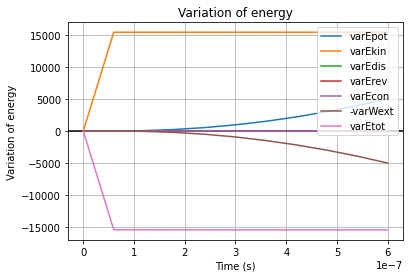

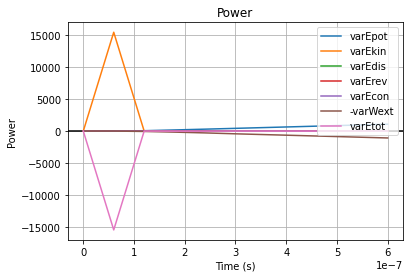

In [12]:
# PlotEnergy(Epot, Ekin, Edis, Erev, Econ, Wext)
PlotVarEnergy(varEpot, varEkin, varEdis, varErev, varEcon, varWext, varEtot)
PlotPower(PEpot, PEkin, PEdis, PErev, PEcon, PWext, PEtot)